# Multi Armed Bandits

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Attempt-to-slow-down-the-greedy-blighter" data-toc-modified-id="Attempt-to-slow-down-the-greedy-blighter-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Attempt to slow down the greedy blighter</a></span></li><li><span><a href="#Visual-for-explanation" data-toc-modified-id="Visual-for-explanation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Visual for explanation</a></span></li><li><span><a href="#Visual-for-the-multi-variant-version" data-toc-modified-id="Visual-for-the-multi-variant-version-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visual for the multi-variant version</a></span></li><li><span><a href="#Print-multiple-egreedy-simulations" data-toc-modified-id="Print-multiple-egreedy-simulations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Print multiple egreedy simulations</a></span></li></ul></div>

This notebook covers simulations of "Multi Armed Bandit" campaigns, which are akin to multi-variant A/B tests, except that the proportion of users placed in each variant changes over time to try to optimise some output metric throughout the experiment (at the detriment of statistical significance)

In [488]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit

# Save default color list for use later
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [476]:
class simulation():
    '''This class covers Multi Armed Bandit objects, including running the simulation and plotting the output'''
    
    def __init__(self, iterations = 10_000, sim_type='random', proportions = [0.1,0.2,0.15,0.3,0.05], epsilon = None):
        '''
        sim_type - (str) one of 'random', 'egreedy', 'slow_greedy', 'Thompson'
        see https://arxiv.org/pdf/1707.02038.pdf for a description of Thompson sampling
        '''
        self.sim_type = sim_type
        self.proportions = proportions
        self.epsilon = epsilon
        self.iterations = iterations

        self.n_bandits = len(self.proportions)
        self.variants = np.arange(self.n_bandits)

        self.results = np.empty((self.iterations,8))
        self.results[:] = np.NaN
        self.count_per_bandit = np.zeros(self.n_bandits)
        self.mean_per_bandit  = np.ones(self.n_bandits)*0.5
        self.stddev_per_bandit = np.zeros(self.n_bandits)
                
        # Successes - \alpha in the literature
        self.successes = np.ones(self.n_bandits)
        # Failures - \beta in the literature
        self.failures = np.ones(self.n_bandits)


    def _choose(self, person):
        '''Choose a variant in one of a number of ways defined by self.sim_type'''
        if self.sim_type=='random':
            return np.random.choice(self.variants)
        elif (self.sim_type=='egreedy') | (self.sim_type=='slow_greedy'):
            # Ramp epsilon down from 1 if early in the simulation for slow_greedy 
            if self.sim_type=='slow_greedy':
                epsilon = (np.exp(-person/1000)+self.epsilon) # Note this will be above 1 at early time, but this doesn't matter to us
            else:
                epsilon = self.epsilon
                
            # 5% random sample, otherwise pick best according to current means
            if np.random.random() < epsilon:
                return np.random.choice(self.variants)
            else:
                return np.argmax(self.mean_per_bandit)
            
        elif self.sim_type=='Thompson':
            return np.argmax(self.mean_per_bandit)

    def run_simulation(self, verbose=True):
        if verbose: print('Running simulation...',end='')
        for person in range(self.iterations):
            # Place person into one of the variants at random
            variant = self._choose(person) 
            outcome = np.random.binomial(1,self.proportions[variant])
            
            # Update successes/failures
            self.successes[variant] += outcome
            self.failures[variant] += 1-outcome
            
            # Get probabilities
            self.count_per_bandit[variant] = self.successes[variant]+self.failures[variant]

            if self.sim_type == 'Thompson':
                # If Thompson sampling, set the mean to a single sample from a beta-distribution defined by the current successes/failure counts
                for v in self.variants:
                    self.mean_per_bandit[v] = np.random.beta(self.successes[v], self.failures[v])
            else:
                # Else calculate the arithmatic mean
                self.mean_per_bandit[variant] = self.successes[variant]/(self.count_per_bandit[variant])
               
            self.stddev_per_bandit[variant] = np.sqrt(self.mean_per_bandit[variant]*(1-self.mean_per_bandit[variant])/self.count_per_bandit[variant])

            self.results[person] = [person, variant, outcome, self.count_per_bandit[variant], self.mean_per_bandit[variant], self.stddev_per_bandit[variant], self.successes[variant], self.failures[variant]]
        
        self.results_df = pd.DataFrame(self.results, columns=['Iteration','Variant','Outcome','Variant_Count','Variant_Mean','Variant_Stddev','Successes','Failures'])

        if verbose: print('Done')
        return self.results
    
    
    def plot_simulation_output(self, verbose=True):
        '''Plots a multiplot of the simulation output'''

        if verbose: print('Plotting...',end='')

        df = self.results_df
        df.Variant = df.Variant.astype('category')
        
        fig,ax = plt.subplots(4,1,figsize=(15,15), gridspec_kw={'height_ratios': [1,3,4,3]})
        #plt.grid(axis='x')
        
        #ax.yticks(range(len(proportions)))
        # Axis formatting
        ax[0].set_ylabel('Variant')
        ax[0].set_title('Variant choice through time')
        ax[0].set_yticks(self.variants)
        lims = min(self.variants)-1,max(self.variants)+1
        ax[0].set_ylim(lims)

        ax[1].set_title('Variant ratios through time')
        ax[1].set_ylabel('Ratio of variants')


        ax[2].set_title('Variant means through time')
        ax[2].set_ylabel('Estimated Mean')
        ax[2].set_yticks(np.arange(0,1,0.2))

        ax[3].set_ylabel('Capture')
        ax[3].set_ylim([0,1.2])
        
        for a in ax[:-1]:
            a.set_xticklabels([])
        ax[-1].set_xlabel('Iteration')

        for a in ax:
            a.set_xlim([-self.iterations/20,self.iterations*1.1])
            
        groups = df.groupby("Variant")
        # Scatter of variant choices
        for name, group in groups:
            ax[0].plot(group["Iteration"], group["Variant"], marker="|", linestyle="", label=name)
            # Swarm plot takes a while to plot
            #sns.swarmplot(group["Iteration"], group["Variant"], ax = ax[0])

        # Stacked area of variant choice proportions
        stacks = df.pivot(index='Iteration',columns='Variant',values='Variant_Count').ffill().fillna(0)
        # Normalise by row
        stacks = stacks.apply(lambda x: x/sum(x), axis=1)
        ax[1].stackplot(stacks.index,  stacks.values.T, alpha = 0.8);
        # Annotate final sample ratios
        y_loc = 0
        for i, j in enumerate(stacks.values[-1]):
            y_loc += j/2
            ax[1].annotate('{:0.2f}'.format(j),(self.iterations*1.005,y_loc), color=colors[i], va='center')
            y_loc += j/2

        # Lineplot of estimates of variant means 
        for i in self.variants:
            data = df[df.Variant==i]
            if self.sim_type=='Thompson':
                line, = ax[2].plot('Iteration', 'Variant_Mean',data=data, marker='.', ms=2, lw=0)
            else:
                line, = ax[2].plot('Iteration', 'Variant_Mean',data=data)
            # Annotate final means
            x,y = self.iterations*1.005,line.get_ydata()[-1]

            ax[2].fill_between(data.Iteration
                            , data.Successes/(data.Successes+data.Failures) - 2*data.Variant_Stddev
                            , data.Successes/(data.Successes+data.Failures) + 2*data.Variant_Stddev
                            , color=colors[i], alpha=0.1)
            
            ax[2].annotate('{:0.2f} (c: {:0.2f})'.format(y, proportions[i]),(x,y), color=colors[i])

        ax[2].set_ylim([0,df.Variant_Mean.max()*1.2]);
        
        # Capture (%age of max expectation) plot
        exp_best = df.Iteration*max(proportions)
        current_score = df.Outcome.cumsum()
        capture = current_score/exp_best
        regret = (exp_best - current_score)/exp_best
        line, = ax[3].plot(capture, c='k', ls='--')
        x,y = line.get_xdata()[-1],line.get_ydata()[-1]
        ax[3].annotate('{:0.2f}'.format(y),(x+self.iterations/150,y), va='center')
        if verbose: print('Done')
        
        
    def animate(self, frames = 100, verbose = True):
        '''Sets the anim property of self to a Matplotlib animation object showing the distributions through time'''
        
        def init():
            return (*lines,)

        def update(i,n,verbose,frames):
            for v in range(n):
                if (self.sim_type == 'egreedy') | (self.sim_type =='slow_greedy'):
                    mean = a_list[v][i]/(a_list[v][i]+b_list[v][i])
                    lines[v].set_data([mean,mean],[0,1]) 
                else:
                    lines[v].set_data([x,stats.beta.pdf(x, a_list[v][i], b_list[v][i])])  
                bar_failure[v].set_height(b_list[v][i])
                bar_success[v].set_height(a_list[v][i])

                text_failure[v].set_position((v, b_list[v][i]))
                text_success[v].set_position((v+0.35, a_list[v][i]))
                text_failure[v].set_text(b_list[v][i])
                text_success[v].set_text(a_list[v][i])
            
            label.set_text('Iteration: {}'.format(i+1))

            if verbose:
                p = int(i/frames*100)
                if p>last_printed:
                    print('\rPercent: {p:3d}'.format(p=p), end='')
                    sys.stdout.flush()
            return (*lines,)
        
        def format_charts(ax):
            ax[0].set_ylim([0,10])
            ax[0].set_yticks([])
            ax[0].set_title('Probability Density Functions')
            ax[0].set_xlabel('Proportion')

            ax[1].set_title('Counts')
            ax[1].set_yticks([])

            for spine in ['top','left','right']:
                ax[0].spines[spine].set_visible(False)
                ax[1].spines[spine].set_visible(False)
        
        last_printed = 0
        fig, ax = plt.subplots(figsize = (15,5))
        gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[5, 1])  # Have thin bottom row to allow space for xlabel in gif (bug stops labels printing correctly otherwise)
        label = fig.text(0.8,0.1,'Iteration: ', ha='left')

        ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

        x = np.linspace(0,1, 100)

        df = pd.DataFrame(self.results, columns=['Iteration','Variant','Outcome','Variant_Count','Variant_Mean','Variant_Stddev','Successes','Failures'])
        # Reshape dataframe to have one column per variant split by success/failure

        stacks = df.pivot(index='Iteration',columns='Variant',values=['Successes','Failures']).ffill().fillna(1).iloc[:frames]

        a_list = stacks.Successes.astype(int)
        b_list = stacks.Failures.astype(int)

        # Get highest value in all distributions for ylim
        idx = (stacks.max().Successes+stacks.max().Failures).argmax()

        # Approx ylim
        if (self.sim_type == 'egreedy') | (self.sim_type == 'slow_greedy'):
            ymax = 1
            ax[0].set_xlim([-0.04,1])
        else:
            ymax = 1.5*stats.beta.pdf(x, stacks.Successes[idx].tail(1), stacks.Failures[idx].tail(1)).max()
        ax[0].annotate('Population Proportions →       ',(0,ymax*0.85), va='center', ha='right', c='grey')
    
        lines = []
        bar_failure = []
        bar_success = []
        text_failure = []
        text_success = []

        # Set up each chart and line
        for v in self.variants:
            ax[0].axvline(self.proportions[v],0.8,0.9, ls=':', color = colors[v])
            if (self.sim_type == 'egreedy') | (self.sim_type == 'slow_greedy'):
                lines.append(ax[0].plot([0.5,0.5],[0,1])[0])
            else:
                lines.append(ax[0].plot(x,stats.beta.pdf(x, 1, 1))[0])
            bar_failure.append(ax[1].bar(v, 1, color='w', edgecolor = colors[v], lw =3, width=0.5, hatch='X')[0])
            bar_success.append(ax[1].bar(v+0.25, 1, facecolor=colors[v], edgecolor=colors[v], lw =3, width=0.5)[0])
            text_failure.append(ax[1].annotate(1,(v,1), va='bottom', ha='center', color = colors[v]))
            text_success.append(ax[1].annotate(1,(v+0.35,1), va='bottom',ha='left', color =colors[v]))

        format_charts(ax)
        ax[1].set_xticks(self.variants+0.125)
        ax[1].set_xticklabels(self.variants, rotation=0)

        # Set the ylimits
        ax[1].set_ylim([0,stacks.max(axis=0).max()*1.2])
        ax[0].set_ylim([0,ymax])

        # Create the animation
        self.anim = animation.FuncAnimation(fig, update, init_func=init,
                                       frames=frames, interval=10,
                                       fargs=(len(self.variants),verbose,frames),
                                       blit=True, repeat=None)

        if verbose:
            print('\rPercent: {:3d}'.format(100), end='')
            sys.stdout.flush()

    

Running simulation...Done
Plotting...Done


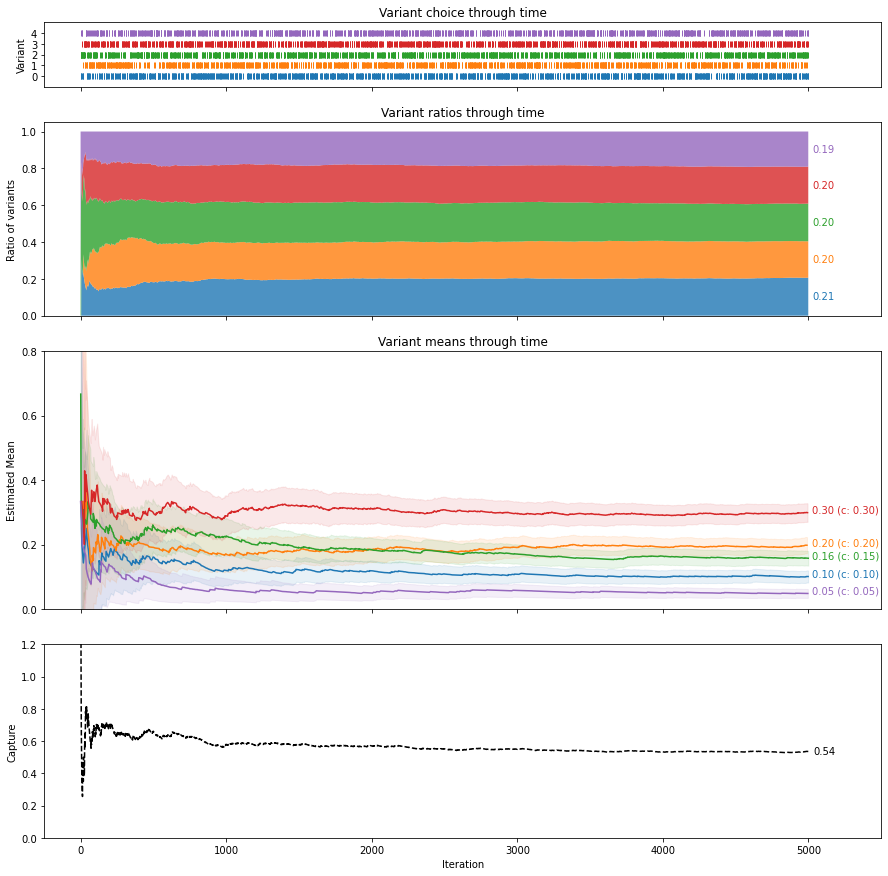

In [445]:
random = simulation(iterations=5_000)
random.run_simulation()
random.plot_simulation_output()


Running simulation...Done
Plotting...Done


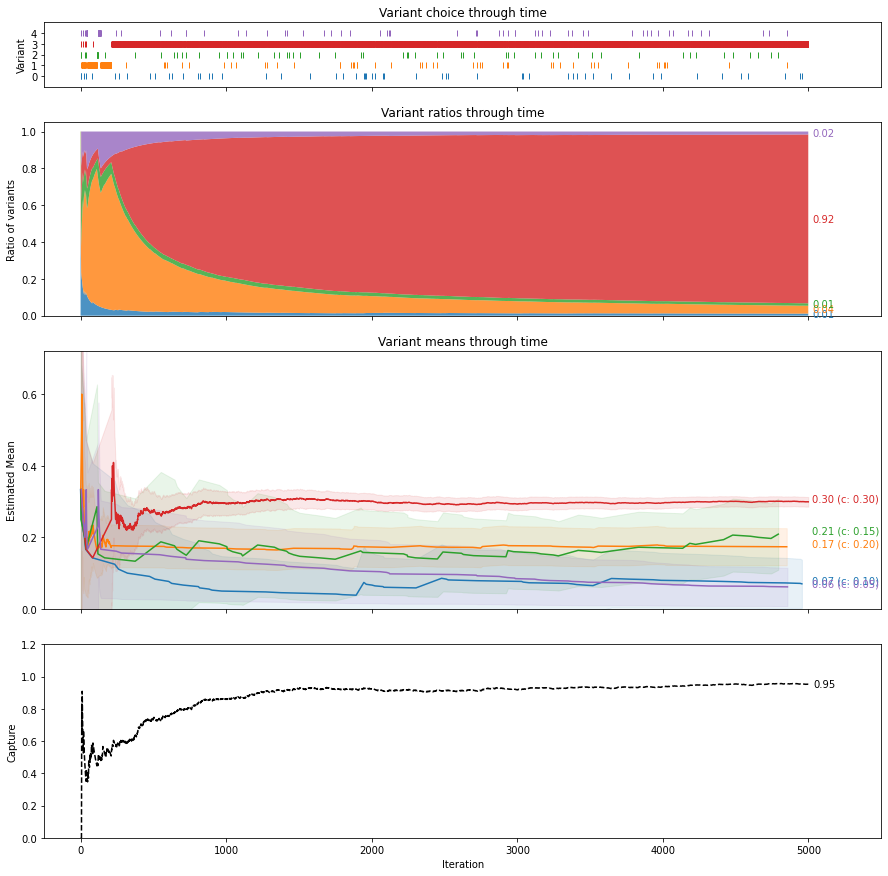

In [464]:
egreedy = simulation(sim_type='egreedy', epsilon = 0.05, iterations=5_000)
egreedy.run_simulation()
egreedy.plot_simulation_output()

## Attempt to slow down the greedy blighter

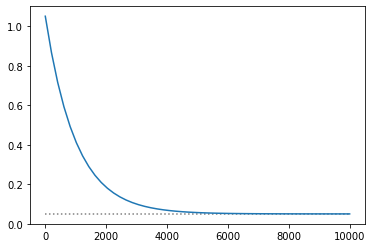

In [648]:
x = np.linspace(0,10_000)
base_epsilon = 0.05

epsilon = (np.exp(-x /1000)+base_epsilon)
plt.plot(x,epsilon)
plt.hlines(base_epsilon,0,10_000, color='grey',ls=':')

Running simulation...Done
Plotting...Done


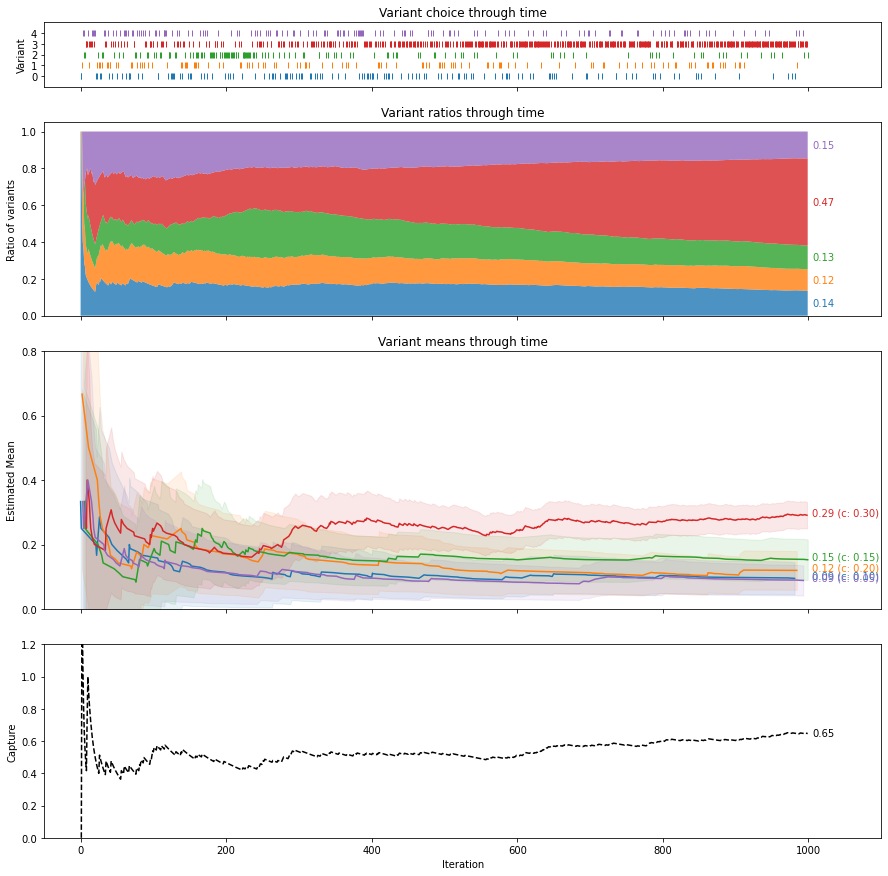

In [484]:
slow_greedy = simulation(sim_type='slow_greedy', epsilon = 0.05, iterations=1_000)
slow_greedy.run_simulation()
slow_greedy.plot_simulation_output()

# Closer proportions in the variants

In these examples, egreedy gets stuck on a sub-optimal variant, whereas the slow-greedy finds the correct one

Running simulation...Done
Plotting...Done


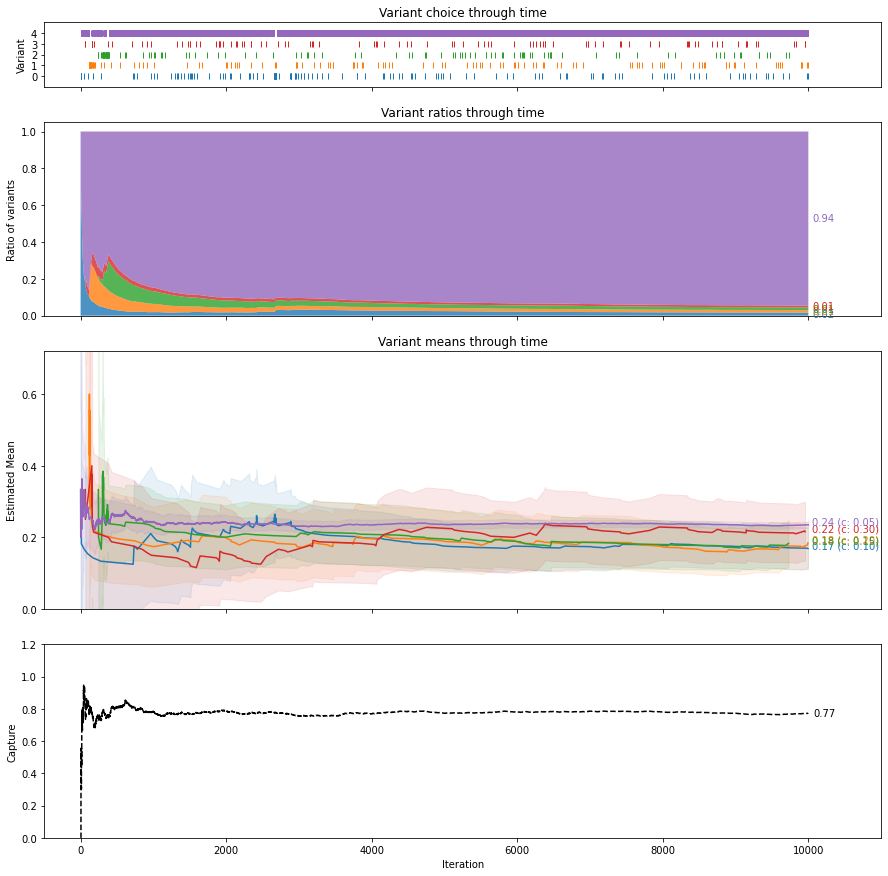

In [319]:
egreedy = simulation(iterations = 10_000, sim_type='egreedy', epsilon = 0.05, proportions = [0.2,0.21,0.22,0.23,0.24])
egreedy.run_simulation()
egreedy.plot_simulation_output()

Running simulation...Done
Plotting...Done


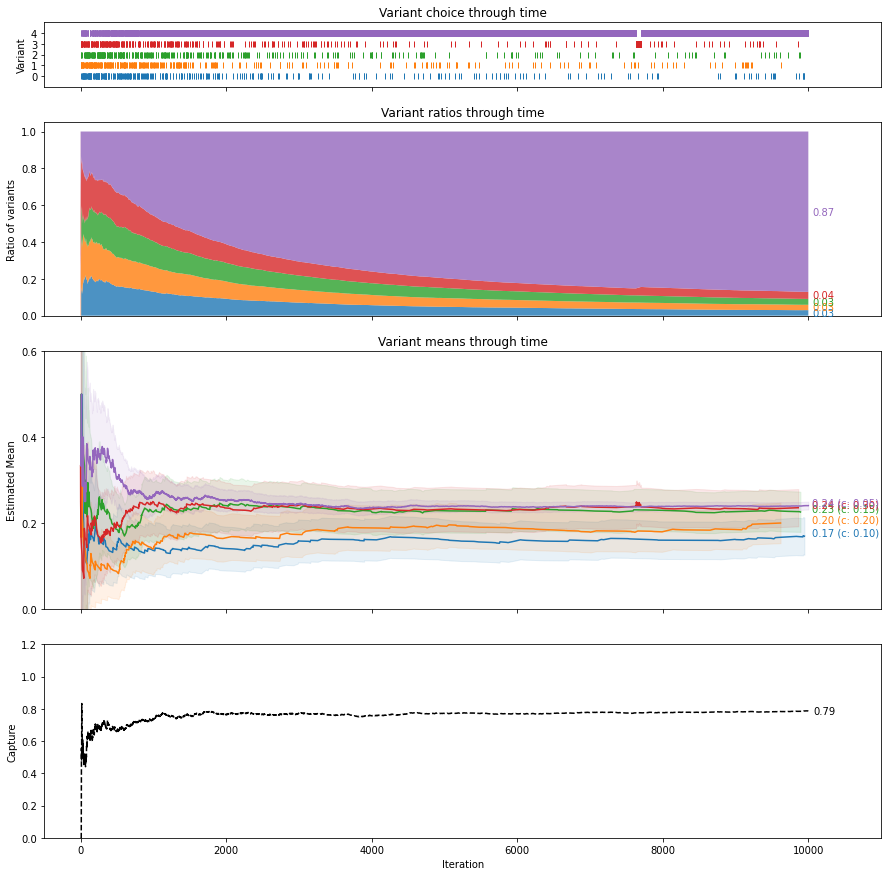

In [395]:
slow_greedy = simulation(iterations = 10_000, sim_type='slow_greedy', epsilon = 0.05, proportions = [0.2,0.21,0.22,0.23,0.24])
slow_greedy.run_simulation()
slow_greedy.plot_simulation_output()

Running simulation...Done
Plotting...Done


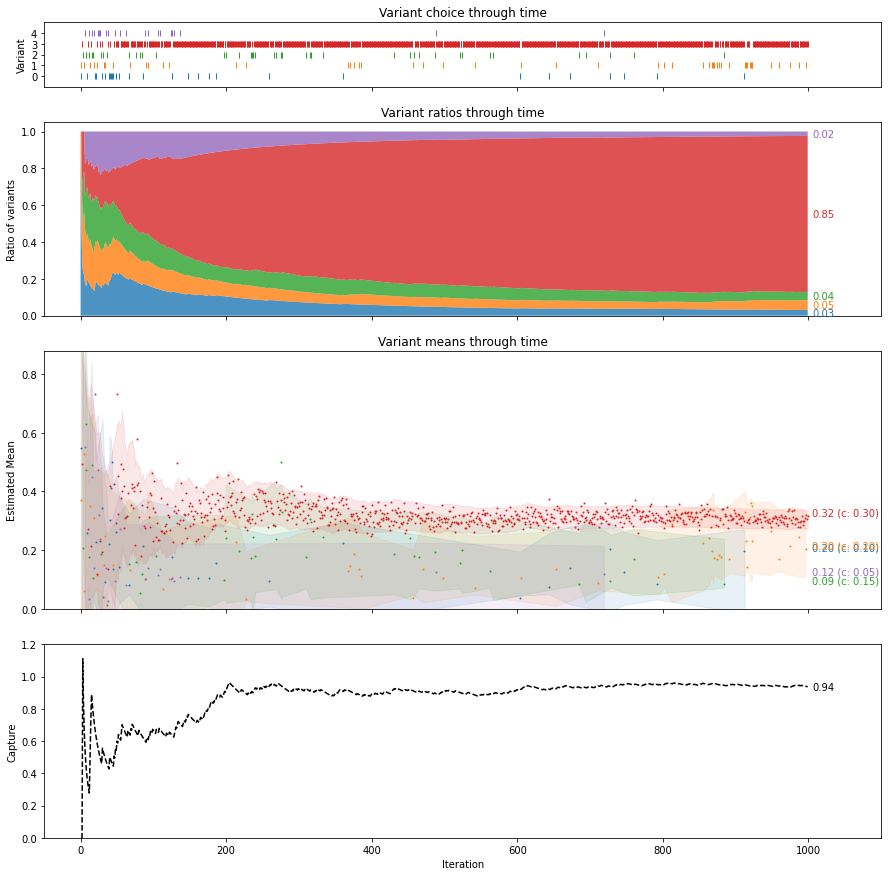

In [453]:
thompson = simulation(sim_type='Thompson', iterations=1_000)
thompson.run_simulation()
thompson.plot_simulation_output()

In [724]:
np.random.beta(1,1)

0.9961227892167901

In [862]:
import plotly.express as px
#fig, ax = plt.subplots(1, 1)
a=1
b=1
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)

results = [np.array([[0]*len(x),x,stats.beta.pdf(x, a, b)]).T]


for i in range(1,400):
    outcome = np.random.binomial(1,0.2)
    a += outcome
    b += 1-outcome
    if i<=40:
        results.append(np.array([[i]*len(x),x,stats.beta.pdf(x, a, b)]).T)   
    elif i%40==0:
        results.append(np.array([[i]*len(x),x,stats.beta.pdf(x, a, b)]).T)   

df = pd.DataFrame(np.concatenate(results), columns=['iteration','x','beta']).sort_values(['iteration','x'])

fig = px.line(df, x='x', y='beta', animation_frame='iteration',range_y=[0,10])

fig.show()


## Visual for explanation


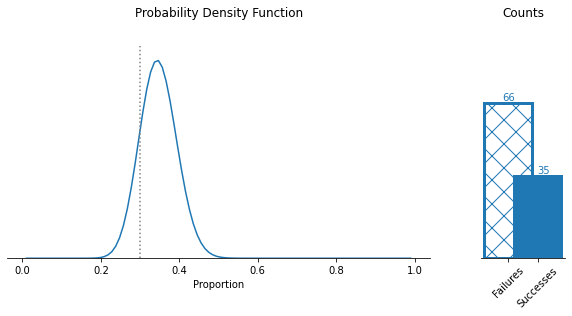

In [487]:
import matplotlib.pyplot as plt
import ffmpeg
import os
from matplotlib import animation, rc, rcParams, gridspec
from IPython.display import HTML, Image
from matplotlib.animation import FFMpegWriter
import sys

# Set the FFmpeg path and defaults for display
plt.rcParams['animation.ffmpeg_path'] = '/Users/paulgstubley/Applications/ffmpeg/bin/ffmpeg'
proportion = 0.3

fig, ax = plt.subplots(figsize = (10,5))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[20, 1])  # Have thin bottom row to allow space for xlabel in gif (bug stops labels printing correctly otherwise)

ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

a=1
b=1
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)

line, = ax[0].plot(x,stats.beta.pdf(x, a, b));

def format_charts(ax):
    ax[0].set_ylim([0,10])
    ax[0].set_yticks([])
    ax[0].set_title('Probability Density Function')
    ax[0].set_xlabel('Proportion')

    ax[1].set_title('Counts')
    ax[1].set_yticks([])
    
    for spine in ['top','left','right']:
        ax[0].spines[spine].set_visible(False)
        ax[1].spines[spine].set_visible(False)

ax[1].set_xticklabels(['','Failures','Successes'], rotation=45)
ax[0].axvline(proportion,0,0.9, ls=':', color = 'grey')

format_charts(ax)
bar, = ax[1].bar(0, b, facecolor='w',  edgecolor = 'C0', lw =3, hatch='X')
bar2, = ax[1].bar(0.5, a,color='C0' ,  edgecolor='C0', lw =3)

text =  ax[1].annotate(b,(0,b), va='bottom', ha='center', color = 'C0')
text2 = ax[1].annotate(a,(0.5,a), va='bottom', color = 'C0')


def init():

    return (line,)

def update(i):
    global a
    global b
    line.set_data([x,stats.beta.pdf(x, a, b)])   
    bar.set_height(b)
    bar2.set_height(a)
    
    text.set_position((0, b))
    text2.set_position((0.5, a))
    text.set_text(b)
    text2.set_text(a)
    
    outcome = np.random.binomial(1,proportion)
    a += outcome
    b += 1-outcome

    return (line,)

frames = 100
ax[1].set_ylim([0,frames])
anim = animation.FuncAnimation(fig, update, init_func=init,
                               frames=frames, interval=50,
                               blit=True, repeat=None)



HTML(anim.to_html5_video())


## Visual for the multi-variant version

In [ ]:
thompson.animate(1000)
HTML(thompson.anim.to_html5_video())


In [ ]:
random.animate(1000)
HTML(random.anim.to_html5_video())

Percent:  99

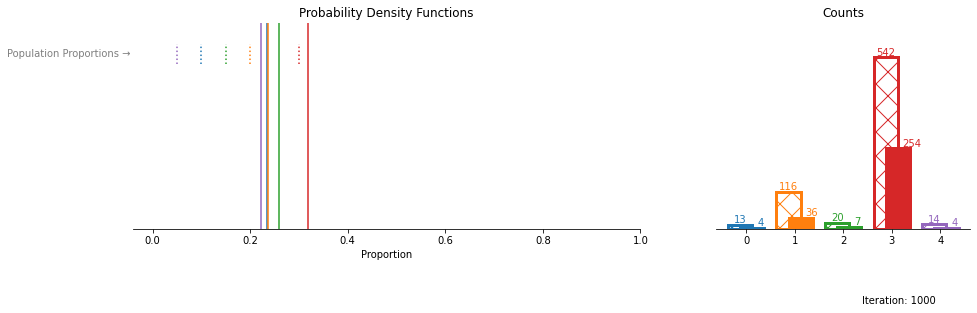

In [444]:
egreedy.animate(1000)
HTML(egreedy.anim.to_html5_video())

## Print multiple egreedy simulations

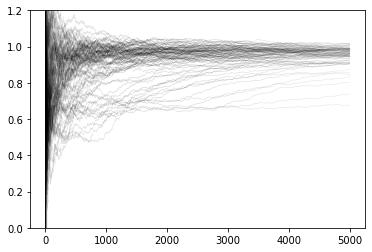

In [480]:
fig, ax = plt.subplots(1,1)

for i in range(100):
    egreedy = simulation(iterations = 5_000, sim_type='egreedy', epsilon = 0.05)
    egreedy.run_simulation(verbose=False)

    exp_best = egreedy.results_df.Iteration*max(proportions)
    current_score = egreedy.results_df.Outcome.cumsum()
    capture = current_score/exp_best
    line, = ax.plot(capture, c='k', ls='-', lw=0.5, alpha=0.1)

ax.set_ylim([0,1.2]);

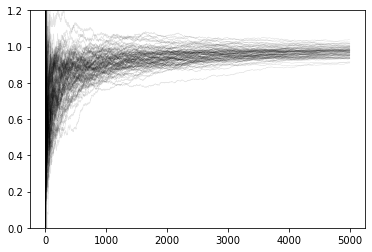

In [481]:
fig, ax = plt.subplots(1,1)

for i in range(100):
    egreedy = simulation(iterations = 5_000, sim_type='Thompson', epsilon = 0.05)
    egreedy.run_simulation(verbose=False)

    exp_best = egreedy.results_df.Iteration*max(proportions)
    current_score = egreedy.results_df.Outcome.cumsum()
    capture = current_score/exp_best
    line, = ax.plot(capture, c='k', ls='-', lw=0.5, alpha=0.1)

ax.set_ylim([0,1.2]);

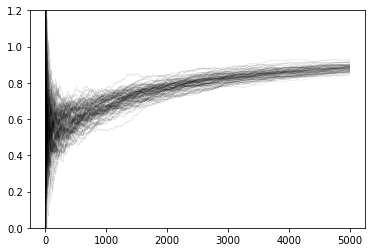

In [483]:
fig, ax = plt.subplots(1,1)

for i in range(100):
    egreedy = simulation(iterations = 5_000, sim_type='slow_greedy', epsilon = 0.05)
    egreedy.run_simulation(verbose=False)

    exp_best = egreedy.results_df.Iteration*max(proportions)
    current_score = egreedy.results_df.Outcome.cumsum()
    capture = current_score/exp_best
    line, = ax.plot(capture, c='k', ls='-', lw=0.5, alpha=0.1)

ax.set_ylim([0,1.2]);